In [1]:
import pandas as pd

# Prepocessing libraries
import emoji
import re
from langdetect import detect
from spellchecker import SpellChecker
import string
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

def detect_lang(text):
    """
    Detects the language of a story.

    Parameters
    ----------
    text : str
        The story to be processed.
    Returns
    -------
    lang : str
        The language of the story.
    """
    try:
        return detect(text)
    except:
        return 'unknown'
    
stop_words = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
tokenizer = WordPunctTokenizer()
spellcheck = SpellChecker()

def preprocess(text):
    """
    Preprocesses a story by removing emojis, punctuations, stopwords, spellchecking and lemmatizing the words.

    Parameters
    ----------
    text : str
        The story to be preprocessed.
    Returns
    -------
    processed_text : str
        The preprocessed story.
    """

    # regex to replace all consecutive occurences of punctuations with a single punctuation
    pattern = r'([' + re.escape(''.join(punc)) + r'])\1+'
    text = re.sub(pattern, r'\1', ''.join(text))

    # regex to remove all numbers
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    tokens = tokenizer.tokenize(text.lower())
    # remove stopwords, punctuations, emojis, correct and lemmatize the words
    tokens = [spellcheck.correction(token) for token in tokens]
    tokens = [token for token in tokens if emoji.is_emoji(token) == False]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punc]
    tokens = [lemma.lemmatize(token) for token in tokens if token]

    processed_text = ' '.join(tokens)
    return processed_text

def preprocess_without_lemmatizing(text):
    """
    Preprocesses a story by removing emojis, punctuations, stopwords, spellchecking the words.

    Parameters
    ----------
    text : str
        The story to be preprocessed.
    Returns
    -------
    processed_text : str
        The preprocessed story.
    """

    # regex to replace all consecutive occurences of punctuations with a single punctuation
    pattern = r'([' + re.escape(''.join(punc)) + r'])\1+'
    text = re.sub(pattern, r'\1', ''.join(text))

    # regex to remove all numbers
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    tokens = tokenizer.tokenize(text.lower())
    # remove stopwords, punctuations, emojis, correct and lemmatize the words
    tokens = [spellcheck.correction(token) for token in tokens]
    tokens = [token for token in tokens if emoji.is_emoji(token) == False]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in punc]

    processed_text = ' '.join(tokens)
    return processed_text

In [2]:
# read the data
file = open("data/stories.csv", "r")
stories_array = []

for line in file:
    stories_array.append(line)

file.close()

data = pd.DataFrame(stories_array, columns=['story'])

Demo: `preprocess()` on a story

In [3]:
print(data['story'][3494])
print(preprocess(data['story'][3494]))

I am an investigative journalist and did a research on the Sugar Mummy scam circus in Singapore. They all operate the same way. No one is what they say they are. I contacted 6 of the agents on Locanto and other sites via WhatsApp and they were all scammers. They might change names but one thing is for 100% sure. You will be scammed! Basically they have a pre-paid phone card with a generic profile photo. They all asure you they are not scammers. After giving them you name, age and civil status they will ask for 300-500 SGDs for a fee. They only accept bank transfer. Then when you have payed this they ask for 1400-1900 SGD for further fees and insurance. They promise you a BMW and a monthly salary of at least 10500 SGD and so on. My conclusion is "DON´T PAY ANYTHING" They are all scammers/fraudsters/liers. Don´t fall for any sweet talk or promises, you will be fooled and no sugar mummy is at the end of the rainbow. No matter who they say they are or that they have lots of clients that re

#### Data preprocessing

In [4]:
# add language column
data["language"] = data["story"].apply(detect_lang)

# filter out non-english stories
data = data[data["language"] == "en"]

# drop language column
data = data.drop(columns=["language"])

Test processing on dataframe of 5 stories

In [5]:
from tqdm.auto import tqdm # to show progress bar while iterating over the stories

tqdm.pandas(desc="Preprocessing stories", colour='#ffaaff')
data["story"][0:5].progress_apply(preprocess)

Preprocessing stories:   0%|          | 0/5 [00:00<?, ?it/s]

0    accepted friend request facebook common friend...
1    whatsapp message good morning baron ya receive...
2    met alan bumble claimed project manager synerg...
3    connected person named ano cab app june normal...
4    person online name june lee initially contacte...
Name: story, dtype: object

Preprocessing the data and saving it

In [6]:
preprocessed_data = data["story"].progress_apply(preprocess)
preprocessed_data.to_csv("data/preprocessed_stories_lemmatized.csv", index=False, header=False)

Preprocessing stories:   0%|          | 0/3489 [00:00<?, ?it/s]

Preprocessing the data without lemmatizing and saving it

In [ ]:
preprocessed_data = data["story"].progress_apply(preprocess)
preprocessed_data.to_csv("data/preprocessed_stories.csv", index=False, header=False)

# Topic Modeling

## LDA


In [69]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def calculate_perplexities(vectorized_stories, no_topics):

    progress_bar = tqdm(total=no_topics, desc='Calculating Perplexities', unit='model') # to show progress bar while iterating over the number of topics

    perplexities = []

    for i in range(1, no_topics+1):
        lda = LatentDirichletAllocation(n_components=i, random_state=0)
        lda.fit(vectorized_stories)
        perplexities.append(lda.perplexity(vectorized_stories))
        progress_bar.update(1)
    
    progress_bar.close()
    return perplexities

def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In order to determine the optimal number of topics, we train LDA models with different number of topics and compute their perplexities. We then take the number of topics that gives the lowest perplexity.

For LDA, we set `random_state=100` for reproducibility.

In [73]:
preprocessed_stories = pd.read_csv("data/processed_stories.csv", header=None, names=["story"])
vectorizer = CountVectorizer(min_df=120)
vectorized_stories = vectorizer.fit_transform(preprocessed_stories["story"])

perplexities = calculate_perplexities(vectorized_stories, 30)

Calculating Perplexities:   0%|          | 0/30 [00:00<?, ?model/s]

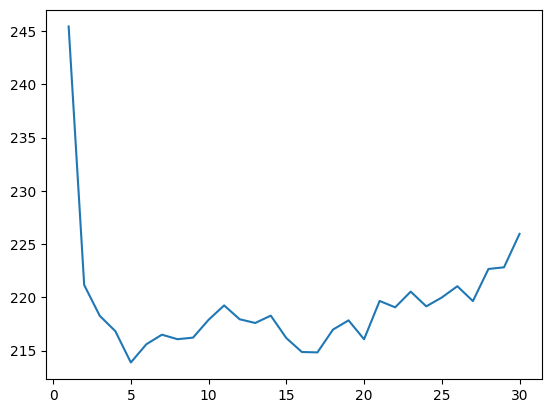

In [74]:
import matplotlib.pyplot as plt

plt.plot(range(1, 31), perplexities)
plt.show()